Original code: https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

Dataset (GTZAN): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# 데이터셋 다운로드

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'username' # username
os.environ['KAGGLE_KEY'] = 'key' # key

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:11<00:00, 126MB/s]
100% 1.21G/1.21G [00:11<00:00, 116MB/s]


In [ ]:
!unzip -q gtzan-dataset-music-genre-classification.zip

# 오디오 파일 이해하기

- y: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- Sampling rate: 1초당 샘플의 개수, 단위 Hz 또는 kHz

In [ ]:
import librosa

y, sr = librosa.load('Data/genres_original/reggae/reggae.00036.wav')

print(y)
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (KHz): 22050
Audio length (seconds): 30.01


## 음악 들어보기

In [ ]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

## 2D 음파 그래프

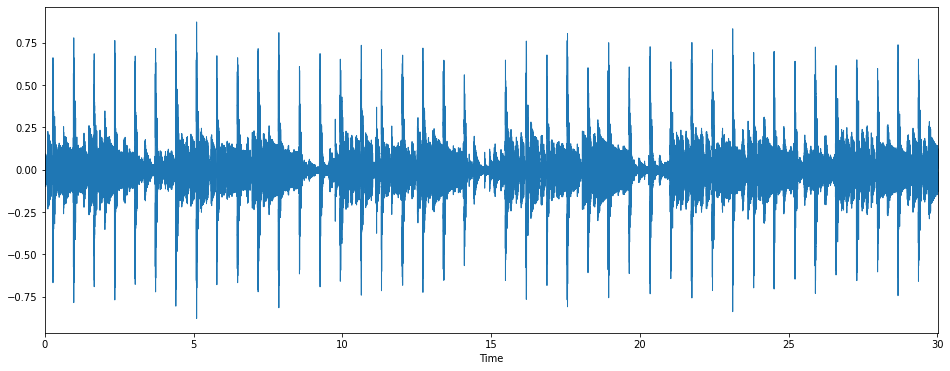

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y=y, sr=sr)
plt.show()

## Fourier Transform

- 시간 영역 데이터를 주파수 영역으로 변경
- y축: 주파수 (로그 스케일)
- color축: 데시벨 (진폭)

(1025, 1293)


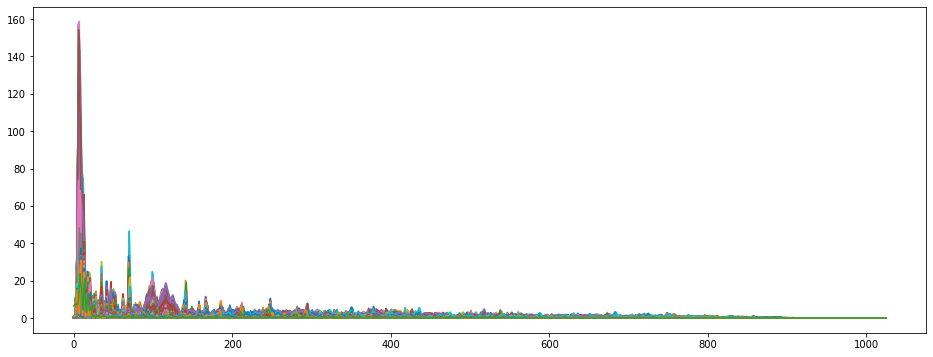

In [ ]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.show()

## Spectogram

- 시간에 따른 신호 주파수의 스펙트럼 그래프
- 다른 이름: Sonographs, Voiceprints, Voicegrams

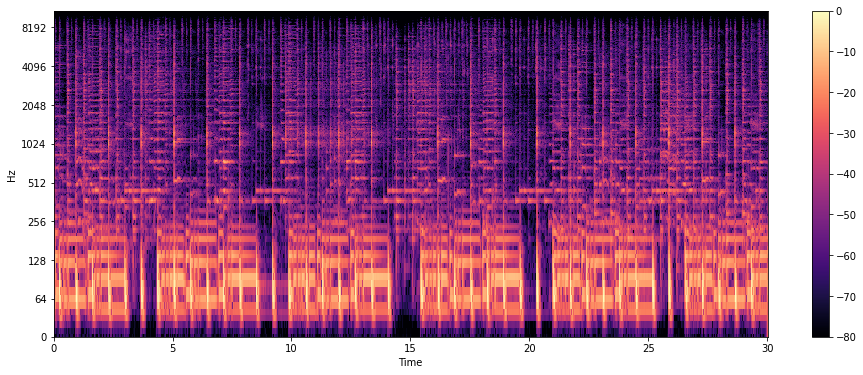

In [ ]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Mel Spectogram

- (인간이 이해하기 힘든) Spectogram의 y축을 Mel Scale로 변환한 것 (Non-linear transformation)
- Mel Scale: https://newsight.tistory.com/294

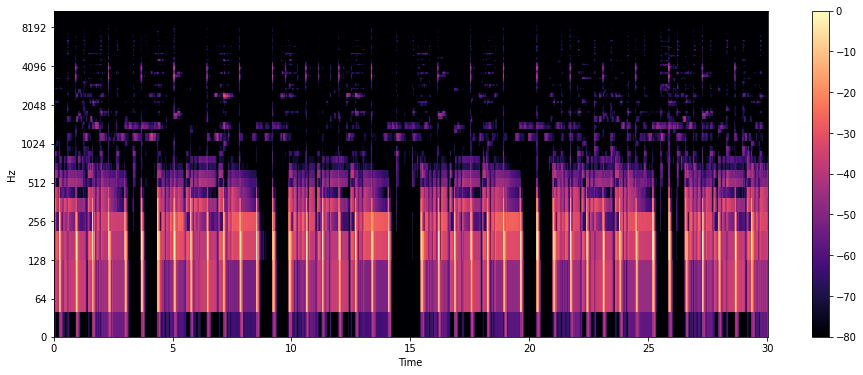

In [ ]:
S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## 레게 vs 클래식 Mel Spectogram

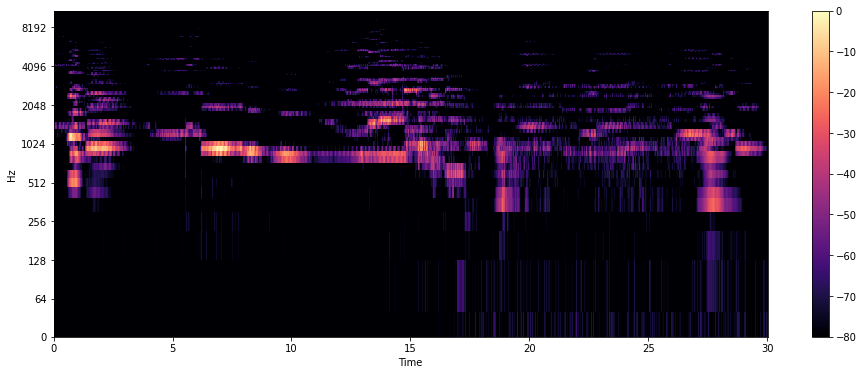

In [ ]:
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

# 오디오 특성 추출 (Audio Feature Extraction)

## Tempo (BPM)

In [ ]:
tempo, _ = librosa.beat.beat_track(y, sr=sr)
print(tempo)

107.666015625


## Zero Crossing Rate

- 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [ ]:
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
39405


### 확대해서 보자

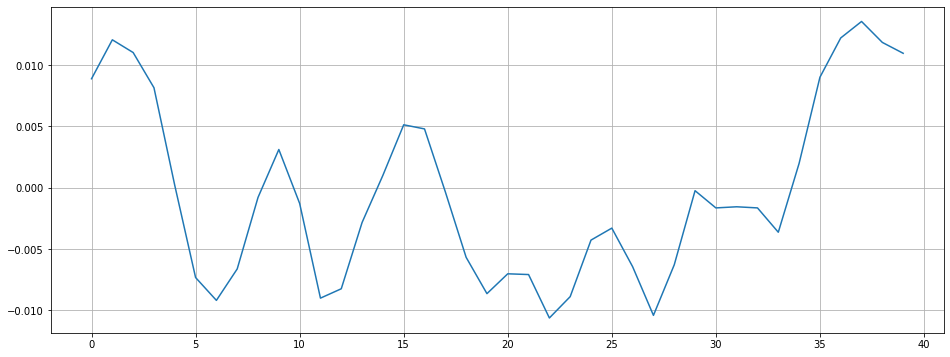

In [ ]:
n0 = 9000
n1 = 9040

plt.figure(figsize=(16, 6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [ ]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

6


## Harmonic and Percussive Components

- Harmonics: 사람의 귀로 구분할 수 없는 특징들 (음악의 색깔)
- Percussives: 리듬과 감정을 나타내는 충격파

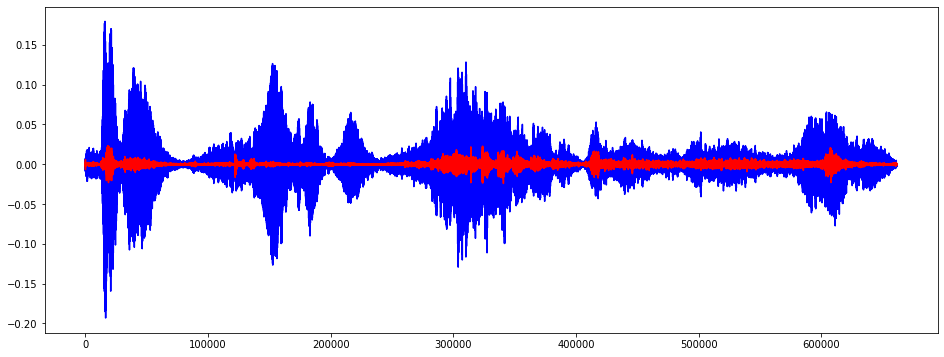

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16, 6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

## Spectral Centroid

- 소리를 주파수 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표
- 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실린다

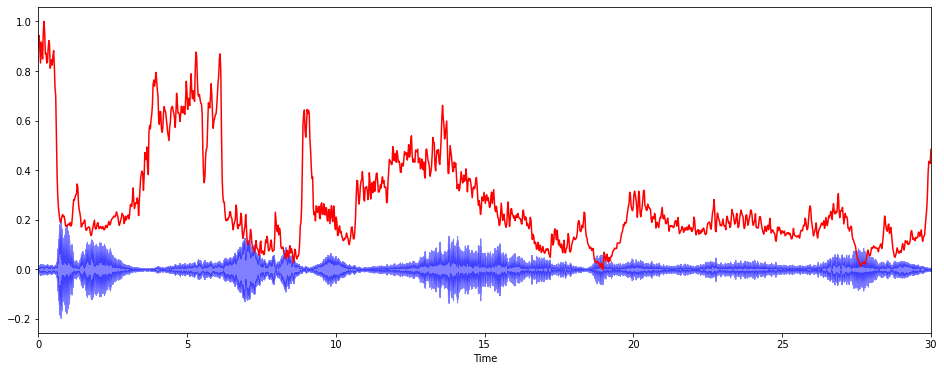

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

# Spectral Rolloff

- 신호 모양을 측정한다
- 총 스펙트럴 에너지 중 낮은 주파수(85% 이하)에 얼마나 많이 집중되어 있는가

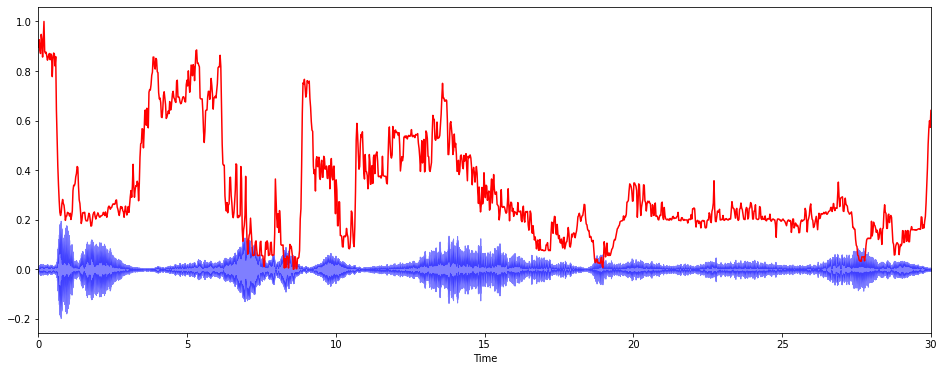

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]

plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)

- MFCCs는 특징들의 작은 집합(약 10-20)으로 스펙트럴 포곡선의 전체적인 모양을 축약하여 보여준다
- 사람의 청각 구조를 반영하여 음성 정보 추출
- https://tech.kakaoenterprise.com/66

mean: 0.48
var: 0.04


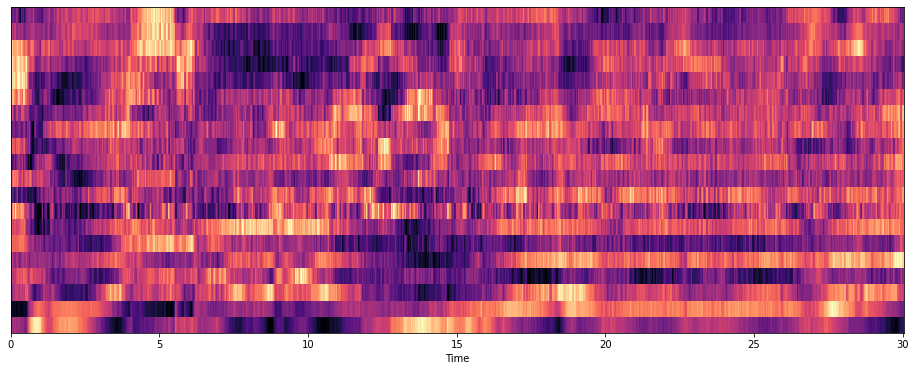

In [ ]:
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs, axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

## Chroma Frequencies

- 크로마 특징은 음악의 흥미롭고 강렬한 표현이다
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반한다
- 모든 스펙트럼을 12개의 Bin으로 표현한다
- 12개의 Bin은 옥타브에서 12개의 각기 다른 반음(Semitones=Chroma)을 의미한다

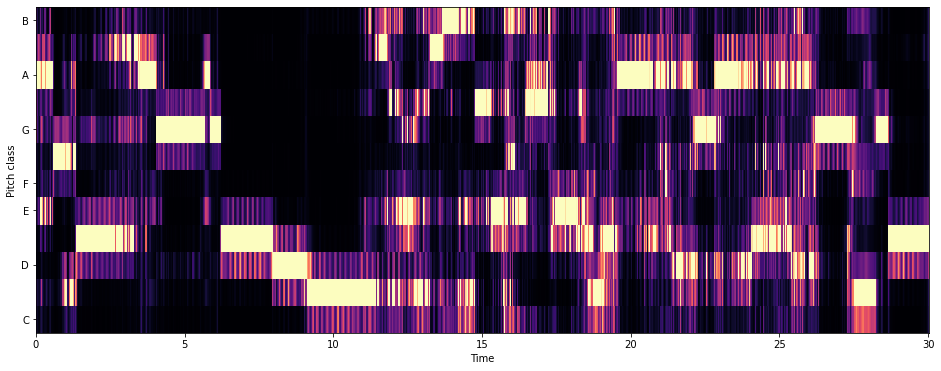

In [ ]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

# 느낀 점

뭔가 특징들을 될 수 있는대로 추출하여 모델에 때려넣으면 알아서 잘 분류하겠지?라는 기도 메타...

# 학습

## 데이터셋 로드

In [ ]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')

df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


## 전처리

In [ ]:
X = df.drop(columns=['filename', 'length', 'label'])
y = df['label']

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns=X.columns)

X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,0.204458,0.008479,0.627798,0.065750,0.558889,0.094009,0.398969,0.705797,0.053666,0.520907,0.049058,0.436564,0.087325,0.612386,0.077451,0.442464,0.092440,0.615847,0.079919,0.401687,0.049143,0.548711,0.143782,0.346570,0.182065,0.471486,0.188510,0.349726,0.089786,0.453269,0.074706,0.376489,0.046738,0.547239,0.050357,0.399156,0.066637,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,0.220384,0.015719,0.627315,0.038963,0.556635,0.082431,0.375552,0.696756,0.044735,0.510794,0.040432,0.451290,0.055461,0.682923,0.060499,0.385907,0.083584,0.630069,0.082378,0.402853,0.135101,0.563791,0.094805,0.376837,0.145341,0.554920,0.102538,0.326362,0.071884,0.426042,0.066947,0.330153,0.040780,0.546890,0.050933,0.380825,0.108298,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,0.173133,0.006448,0.628102,0.098196,0.567421,0.073998,0.375552,0.687860,0.083848,0.482928,0.048348,0.483199,0.045925,0.683410,0.061136,0.498369,0.076570,0.666625,0.069380,0.436689,0.122999,0.527851,0.089802,0.366354,0.271352,0.472968,0.059395,0.369542,0.062476,0.475571,0.059796,0.376549,0.058360,0.515473,0.030699,0.481771,0.078810,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,0.167277,0.004587,0.629326,0.065471,0.564424,0.100660,0.375552,0.706313,0.055188,0.547621,0.063054,0.461877,0.025883,0.599954,0.078755,0.365562,0.086912,0.619799,0.133131,0.422114,0.092336,0.557104,0.126007,0.358830,0.158894,0.501274,0.071605,0.315785,0.077950,0.456012,0.064220,0.381356,0.093799,0.559949,0.041571,0.353526,0.069696,0.386258,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,0.169278,0.004355,0.630608,0.075828,0.556466,0.099061,0.375552,0.722236,0.046525,0.557220,0.040977,0.455376,0.040963,0.603178,0.043292,0.354883,0.059964,0.600390,0.083799,0.407559,0.061604,0.561470,0.086810,0.295722,0.210794,0.515745,0.108017,0.394926,0.072840,0.544897,0.071432,0.361231,0.068626,0.500581,0.024291,0.386226,0.061869,0.438567,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713


## 데이터셋 분할

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7992, 57) (7992,)
(1998, 57) (1998,)


## 학습 및 검증

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

y_preds = xgb.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test, y_preds))

Accuracy: 0.88


## Confusion Matrix

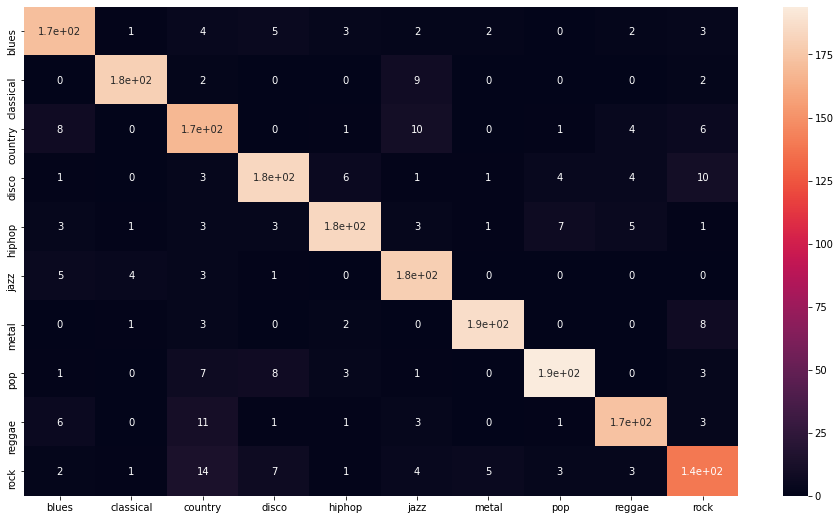

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True, 
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

In [ ]:
for feature, importance in zip(X_test.columns, xgb.feature_importances_):
  print('%s: %.2f' % (feature, importance))

chroma_stft_mean: 0.04
chroma_stft_var: 0.03
rms_mean: 0.02
rms_var: 0.03
spectral_centroid_mean: 0.02
spectral_centroid_var: 0.02
spectral_bandwidth_mean: 0.05
spectral_bandwidth_var: 0.01
rolloff_mean: 0.02
rolloff_var: 0.03
zero_crossing_rate_mean: 0.02
zero_crossing_rate_var: 0.01
harmony_mean: 0.02
harmony_var: 0.02
perceptr_mean: 0.02
perceptr_var: 0.08
tempo: 0.02
mfcc1_mean: 0.02
mfcc1_var: 0.03
mfcc2_mean: 0.01
mfcc2_var: 0.01
mfcc3_mean: 0.01
mfcc3_var: 0.02
mfcc4_mean: 0.04
mfcc4_var: 0.02
mfcc5_mean: 0.01
mfcc5_var: 0.03
mfcc6_mean: 0.02
mfcc6_var: 0.01
mfcc7_mean: 0.01
mfcc7_var: 0.03
mfcc8_mean: 0.01
mfcc8_var: 0.01
mfcc9_mean: 0.02
mfcc9_var: 0.01
mfcc10_mean: 0.01
mfcc10_var: 0.01
mfcc11_mean: 0.01
mfcc11_var: 0.01
mfcc12_mean: 0.03
mfcc12_var: 0.01
mfcc13_mean: 0.01
mfcc13_var: 0.01
mfcc14_mean: 0.01
mfcc14_var: 0.01
mfcc15_mean: 0.01
mfcc15_var: 0.01
mfcc16_mean: 0.01
mfcc16_var: 0.01
mfcc17_mean: 0.01
mfcc17_var: 0.00
mfcc18_mean: 0.01
mfcc18_var: 0.01
mfcc19_mean: 0

# 간단한 추천 시스템

In [ ]:
df_30 = pd.read_csv('Data/features_30_sec.csv', index_col='filename')

labels = df_30[['label']]
df_30 = df_30.drop(columns=['length', 'label'])

df_30_scaled = sklearn.preprocessing.scale(df_30)

df_30 = pd.DataFrame(df_30_scaled, columns=df_30.columns)

df_30.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.350137,0.312587,-0.010690,-0.061856,-0.583585,-0.848311,-0.456402,-0.531042,-0.486473,-0.661934,-0.492045,-0.734349,0.190503,-0.374992,0.372757,0.004326,0.125363,0.308470,-0.427445,0.703093,-0.936398,-0.472691,-0.810844,0.364665,-0.596842,-0.427321,-0.064236,0.337174,-0.555972,-0.863154,-0.834432,0.499518,-0.469595,-0.637704,-0.161187,0.409259,-0.499715,-0.338368,-0.361478,0.645385,-0.534410,0.182190,-0.804350,0.792287,-0.703092,-0.265558,-0.386528,-0.086396,-0.246114,0.500462,-0.780265,-0.237040,-0.643177,0.006723,-0.300597,0.604064,-0.512988
1,-0.462482,1.117572,-0.532852,-0.186821,-0.938516,-0.234194,-0.386852,0.796252,-0.648681,0.795823,-1.138098,-0.509142,0.300346,-0.638821,0.201327,-0.401242,-1.823211,-0.629159,1.450498,0.780355,-0.334107,0.824518,0.364197,-0.024903,0.379233,0.331730,1.047768,0.581136,0.427304,-0.345368,1.447335,1.267113,1.324885,-0.375082,1.964355,0.525720,0.616232,0.068309,0.777162,0.134770,0.844129,0.415775,-0.089246,0.487075,0.243616,-0.439903,-0.308424,-0.048102,-0.159175,0.711371,-0.069304,-0.054982,-0.453456,0.544806,-0.407087,0.424127,-0.538421
2,-0.184225,-0.137701,0.679978,-0.084093,-0.906885,-0.781694,-0.940663,-0.630916,-0.971592,-0.744406,-0.653615,-0.654970,0.218667,0.326420,0.347559,0.275132,1.486499,0.536542,-0.154859,1.305820,-0.451434,-0.930524,-0.196882,-0.276658,-0.657236,-1.051119,-0.187760,0.940642,-0.769769,-0.859126,-0.160786,0.145416,0.447890,-0.578467,-0.585672,0.250711,-0.376536,-1.043902,-0.466202,0.196577,-0.128510,-0.666723,-0.225923,-0.571108,-0.204831,-1.100347,-0.775892,0.284825,-0.596243,-0.827516,-0.448091,-0.600983,-0.329519,-0.295934,-0.527297,-0.296189,-0.874954
3,0.319639,0.990659,0.154810,0.907029,-1.581429,-0.712095,-1.228256,0.304565,-1.516390,-0.246530,-1.681901,-0.848243,0.217688,0.559304,0.352167,-0.455263,-1.999337,-0.549727,0.635439,1.613805,-0.570503,0.672652,-0.735629,-0.566353,-0.535209,0.238738,0.929630,-0.033756,-0.006399,0.029896,0.677480,-0.079621,-0.168794,0.753024,0.089860,0.051406,-0.283790,0.413939,0.909995,0.239500,-0.626167,0.375494,-0.334130,-0.571569,-0.071855,0.204986,-0.331163,-0.080249,-0.482843,0.142153,-0.371370,0.033427,-0.767591,0.455409,-0.779744,-0.602881,-0.844508
4,-0.859077,0.194163,-0.600165,-0.205909,-0.512542,-0.315178,-0.939770,-0.504463,-0.630107,-0.190517,-0.051477,-0.341504,0.206982,-0.663318,0.356208,-0.396513,0.583851,-0.158363,0.522689,0.851515,0.334666,-1.230061,-0.468619,-0.849189,-0.232324,-2.565139,1.607193,-0.319529,0.111037,-1.834162,-0.395916,-0.919937,0.888988,-0.579650,1.051479,-0.822167,0.488682,-1.037241,0.123382,-1.085384,0.544625,-0.346598,0.654352,-1.864732,0.179457,-1.087083,0.381255,-1.238616,0.751318,-0.327220,0.377620,-0.368375,-0.293696,-0.553016,-0.089383,-2.766009,-0.330287


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(df_30)

sim_df = pd.DataFrame(similarity, index=labels.index, columns=labels.index)

sim_df.head()

filename,blues.00000.wav,blues.00001.wav,blues.00002.wav,blues.00003.wav,blues.00004.wav,blues.00005.wav,blues.00006.wav,blues.00007.wav,blues.00008.wav,blues.00009.wav,blues.00010.wav,blues.00011.wav,blues.00012.wav,blues.00013.wav,blues.00014.wav,blues.00015.wav,blues.00016.wav,blues.00017.wav,blues.00018.wav,blues.00019.wav,blues.00020.wav,blues.00021.wav,blues.00022.wav,blues.00023.wav,blues.00024.wav,blues.00025.wav,blues.00026.wav,blues.00027.wav,blues.00028.wav,blues.00029.wav,blues.00030.wav,blues.00031.wav,blues.00032.wav,blues.00033.wav,blues.00034.wav,blues.00035.wav,blues.00036.wav,blues.00037.wav,blues.00038.wav,blues.00039.wav,...,rock.00060.wav,rock.00061.wav,rock.00062.wav,rock.00063.wav,rock.00064.wav,rock.00065.wav,rock.00066.wav,rock.00067.wav,rock.00068.wav,rock.00069.wav,rock.00070.wav,rock.00071.wav,rock.00072.wav,rock.00073.wav,rock.00074.wav,rock.00075.wav,rock.00076.wav,rock.00077.wav,rock.00078.wav,rock.00079.wav,rock.00080.wav,rock.00081.wav,rock.00082.wav,rock.00083.wav,rock.00084.wav,rock.00085.wav,rock.00086.wav,rock.00087.wav,rock.00088.wav,rock.00089.wav,rock.00090.wav,rock.00091.wav,rock.00092.wav,rock.00093.wav,rock.00094.wav,rock.00095.wav,rock.00096.wav,rock.00097.wav,rock.00098.wav,rock.00099.wav
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,1.000000,0.049231,0.589618,0.284862,0.025561,-0.346688,-0.219483,-0.167626,0.641877,-0.097889,-0.004725,-0.138701,0.022420,0.170770,-0.100287,-0.061984,0.038424,0.070591,-0.043250,-0.032994,0.506165,-0.103861,-0.153357,-0.021814,-0.068566,-0.103846,-0.286219,-0.017917,0.019182,-0.245793,-0.158164,-0.203505,-0.238364,-0.245459,-0.182820,0.016867,-0.108189,-0.377991,-0.102337,-0.288664,...,-0.180951,-0.357947,-0.499987,-0.583565,0.582948,0.455372,-0.117475,0.291773,0.535460,0.111680,-0.018038,0.616646,0.616184,0.619470,0.737537,0.391488,0.386102,0.524411,0.383944,0.635159,0.483003,0.338310,0.341182,0.704877,0.468150,-0.165756,-0.033461,0.655153,0.271846,0.484170,-0.082829,0.546169,0.578558,0.662590,0.571629,0.610942,0.640835,0.496294,0.284958,0.304098
blues.00001.wav,0.049231,1.000000,-0.096834,0.520903,0.080749,0.307856,0.318286,0.415258,0.120649,0.404168,0.187969,0.537564,0.116593,0.138999,0.372891,0.339293,0.243391,0.293110,0.242766,0.350323,0.173128,0.374270,0.433072,0.041210,0.293562,0.208121,0.265333,0.069686,0.193576,0.315657,0.197519,0.174806,0.336295,0.264876,0.151645,0.155828,0.129249,0.296153,0.236439,0.296356,...,-0.292708,0.038637,-0.141359,0.418910,-0.177155,-0.108917,0.554469,0.031773,-0.153006,0.026416,-0.086265,-0.040695,-0.088279,-0.219520,-0.169743,0.043461,0.234076,-0.143892,0.226681,-0.234705,-0.254766,0.087614,-0.204128,-0.241611,-0.207278,0.031050,0.220761,-0.295174,-0.133969,0.047796,-0.098111,-0.325126,-0.370792,-0.191698,-0.330834,-0.077301,-0.222119,-0.302573,0.499562,0.311723
blues.00002.wav,0.589618,-0.096834,1.000000,0.210411,0.400266,-0.082019,-0.028061,0.104446,0.468113,-0.132532,0.220436,0.057667,0.214217,0.026326,-0.174039,-0.091717,0.042537,0.056512,-0.294934,0.037617,0.287231,-0.181328,-0.235117,0.129427,-0.020690,-0.191341,-0.372636,-0.058686,0.120372,0.075361,0.216751,0.196171,0.082313,0.175337,0.256547,0.392760,0.325772,-0.130494,0.242670,0.045100,...,-0.386603,-0.475932,-0.462687,-0.531435,0.657971,0.434122,-0.034768,0.271837,0.451977,0.175507,0.234224,0.450491,0.417995,0.488881,0.503598,0.348458,0.357615,0.455360,0.404612,0.631893,0.443831,0.326861,0.241868,0.550154,0.420591,0.109318,0.109191,0.594156,0.192450,0.566140,-0.032408,0.561074,0.590779,0.583293,0.514537,0.495707,0.566837,0.589983,0.216378,0.321069
blues.00003.wav,0.284862,0.520903,0.210411,1.000000,0.126437,0.134796,0.300746,0.324566,0.352758,0.295184,0.339783,0.414037,0.103369,0.220996,0.224956,0.228406,0.042363,0.261825,0.065738,0.303616,0.225934,0.248292,0.260467,0.101586,0.330638,0.255722,0.167251,0.160013,0.378844,0.163240,0.115658,0.078846,0.199018,0.076584,0.028351,0.183075,0.142251,0.039

In [ ]:
def find_similar_songs(name, n=5):
  series = sim_df[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

find_similar_songs('rock.00000.wav')

,rock.00000.wav
filename,
rock.00079.wav,0.681819
rock.00026.wav,0.677842
country.00070.wav,0.675324
rock.00064.wav,0.662020
rock.00096.wav,0.654814
